data is read from https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/stackoverflow.csv

original data source : https://www.kaggle.com/stackoverflow/stacksample?select=Answers.csv

1. importing the libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install scikit-multilearn

You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd

import ast

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import time

In [33]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV
from skmultilearn.problem_transform import LabelPowerset

from sklearn import metrics
from sklearn.metrics import hamming_loss, jaccard_score, f1_score, classification_report

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

2. Read data

In [6]:
# data = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/stackoverflow.csv')
# data = pd.read_csv('https://www.kaggle.com/stackoverflow/stacksample?select=Answers.csv')
data = pd.read_csv('stackoverflow.csv')
data

,Unnamed: 0,Text,Tags
0,2,aspnet site maps has anyone got experience cre...,"['sql', 'asp.net']"
1,4,adding scripting functionality to net applicat...,"['c#', '.net']"
2,5,should i use nested classes in this case i am ...,['c++']
3,6,homegrown consumption of web services i have b...,['.net']
4,8,automatically update version number i would li...,['c#']
...,...,...,...
48971,1262668,using lambda in default initializer gcc vs cla...,['c++']
48972,1262834,stl list very bad performance it is supposed t...,['c++']
48973,1262915,how to use a dict to subset a dataframe say i ...,['python']
48974,1263065,is there a way to use itertools in python to c...,['python']


In [7]:
data.rename(columns = {'Unnamed: 0':'Initial ID'}, inplace = True)

In [8]:
# data.head(10)
data

,Initial ID,Text,Tags
0,2,aspnet site maps has anyone got experience cre...,"['sql', 'asp.net']"
1,4,adding scripting functionality to net applicat...,"['c#', '.net']"
2,5,should i use nested classes in this case i am ...,['c++']
3,6,homegrown consumption of web services i have b...,['.net']
4,8,automatically update version number i would li...,['c#']
...,...,...,...
48971,1262668,using lambda in default initializer gcc vs cla...,['c++']
48972,1262834,stl list very bad performance it is supposed t...,['c++']
48973,1262915,how to use a dict to subset a dataframe say i ...,['python']
48974,1263065,is there a way to use itertools in python to c...,['python']


In [9]:
print('Shape of the dataset : ', data.shape)

Shape of the dataset :  (48976, 3)


In [10]:
data.dtypes

Initial ID     int64
Text          object
Tags          object
dtype: object

3. Data Preprocessing : **bold text**

count number of tags in a question and frequency of  each tag:

In [11]:
data['tag_count'] = data['Tags'].apply(lambda x : len(x.split()))
data

,Initial ID,Text,Tags,tag_count
0,2,aspnet site maps has anyone got experience cre...,"['sql', 'asp.net']",2
1,4,adding scripting functionality to net applicat...,"['c#', '.net']",2
2,5,should i use nested classes in this case i am ...,['c++'],1
3,6,homegrown consumption of web services i have b...,['.net'],1
4,8,automatically update version number i would li...,['c#'],1
...,...,...,...,...
48971,1262668,using lambda in default initializer gcc vs cla...,['c++'],1
48972,1262834,stl list very bad performance it is supposed t...,['c++'],1
48973,1262915,how to use a dict to subset a dataframe say i ...,['python'],1
48974,1263065,is there a way to use itertools in python to c...,['python'],1


In [12]:
data.dtypes

Initial ID     int64
Text          object
Tags          object
tag_count      int64
dtype: object

In [13]:
# print(data['Tags'].iloc[0].dtype)
print(type(data['Tags'].iloc[0]))

<class 'str'>


converting each tag in data['Tags'] from string to list of strings

In [ ]:
# def stringToList(s):
#     # listRes = list(string.split(","))
#     listRes = s.split(",")
#     return listRes

# https://appdividend.com/2019/11/12/how-to-convert-python-string-to-list-example/

In [14]:
data['Tags'] = data['Tags'].apply(lambda x : ast.literal_eval(x))
print(type(data['Tags'].iloc[0]))
"""when converting to other type from string 
its better to use eval() with abstract syntax tree(ast)
"""

<class 'list'>


'when converting to other type from string \nits better to use eval() with abstract syntax tree(ast)\n'

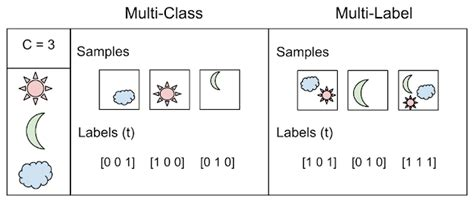

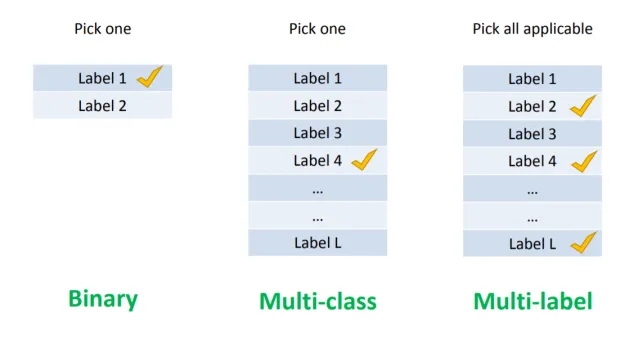

In a multi class classification, output can take one value form  a set of values at a time.

In a multi label classification, output can have multiple values at a time. 

In [15]:
data.dtypes

Initial ID     int64
Text          object
Tags          object
tag_count      int64
dtype: object

In [16]:
y = data['Tags']
y
type(y[0])

list

examples of multi label binarizer :

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html

https://www.programcreek.com/python/example/85906/sklearn.preprocessing.MultiLabelBinarizer


4. basic data analysis on Tag

In [17]:
print(data['tag_count'].value_counts())

1    38751
2     8963
3     1099
4      160
5        3
Name: tag_count, dtype: int64


In [18]:
print( "Maximum number of tags in a question: ", data['tag_count'].max())
print( "Minimum number of tags in a question: ", data['tag_count'].min())
print( "Average number of tags in a question: ", round(data['tag_count'].mean(), 3))

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  1.238


Text(0, 0.5, 'Frequency (log scaled)')

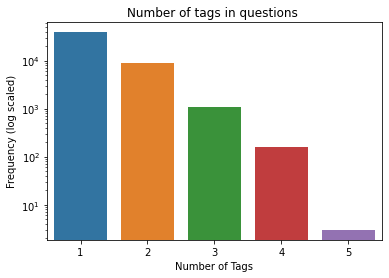

In [19]:
# fig = plt.gcf()
# fig.set_size_inches( 10, 8)
fig = sns.countplot(data['tag_count'])
plt.yscale('log')
plt.title("Number of tags in questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency (log scaled)")

convert to multi label binarizer

In [20]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['Tags'])

In [21]:
y

array([[0, 0, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
mlb.classes_

array(['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'css', 'html',
       'ios', 'iphone', 'java', 'javascript', 'jquery', 'mysql',
       'objective-c', 'php', 'python', 'ruby', 'ruby-on-rails', 'sql'],
      dtype=object)

making another dataframe with y and labels as features/columns

In [23]:
tagMatrix = pd.DataFrame(y, columns = mlb.classes_)
# tagMatrix
tagMatrix.shape

(48976, 20)

In [ ]:
# count1 = 0;
# for val in tagMatrix['sql'] :
#     if(val == 1) : count1+=1;
# print(count1)

# count = tagMatrix['sql'].sum()
# print(count)

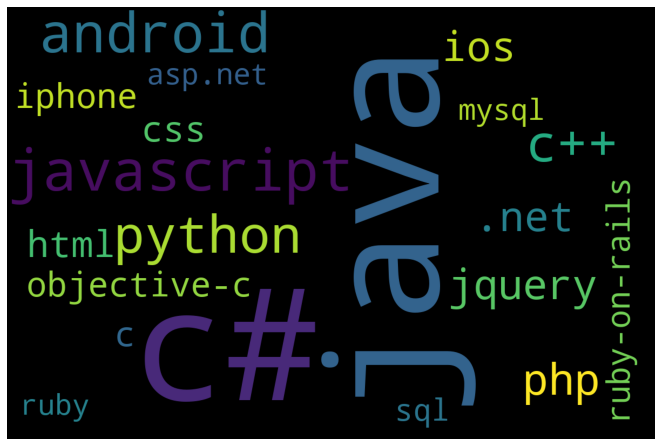

In [24]:
tag_freq_table = {}
for tag in tagMatrix.columns:
    # print(tag)
    tag_freq_table[tag] = tagMatrix[tag].sum()

# tag_freq_table
word_cloud = WordCloud(width=1200,height=800,).generate_from_frequencies(tag_freq_table)
plt.figure(figsize = (10,6))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

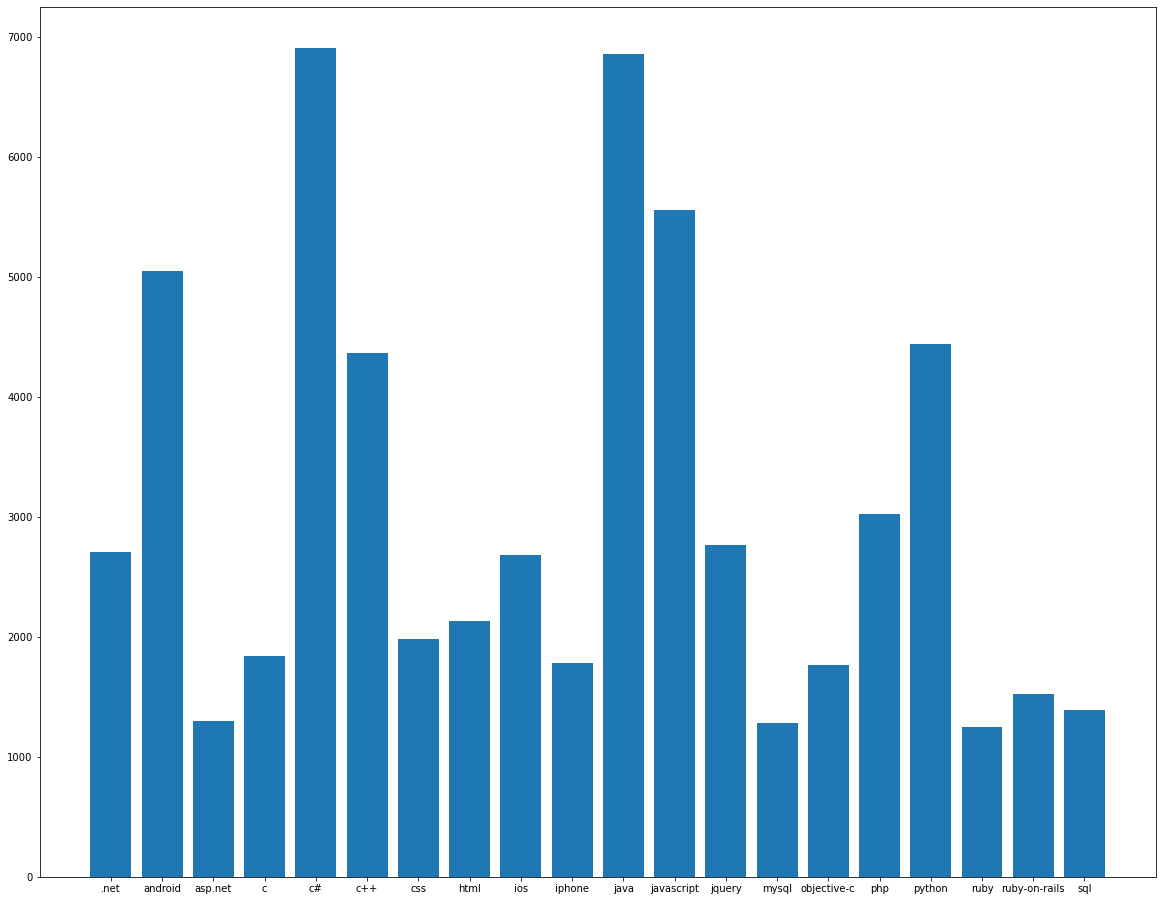

In [25]:
names = list(tag_freq_table.keys())
values = list(tag_freq_table.values())

plt.figure(figsize = (20,16))
plt.bar(range(len(tag_freq_table)),values,tick_label=names)
plt.show()


In [ ]:
# #Bar plot of top 20 tags
# tagMatrix.sort().head(20).plot(kind='bar')
# plt.title('Frequency of top 20 tags')
# plt.xticks(i, tag_df_sorted['Tags'])
# plt.xlabel('Tags')
# plt.ylabel('Counts')
# plt.show()

In [26]:
# tfidf = TfidfVectorizer(analyzer='word', max_features=1000, ngram_range=(1,3), stop_words='english')
tfidf = TfidfVectorizer(analyzer='word',ngram_range=(1,3), stop_words='english')
X = tfidf.fit_transform(data['Text'])
X
# https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/

<48976x6099568 sparse matrix of type '<class 'numpy.float64'>'
	with 9341919 stored elements in Compressed Sparse Row format>



*   Term Frequency (TF):

        Term frequency (TF) often used in Text Mining, NLP and Information Retrieval tells you how frequently a term occurs in a document. In the context natural language, terms correspond to words or phrases. Since every document is different in length, it is possible that a term would appear more often in longer documents than shorter ones. Thus, term frequency is often divided by the  the total number of terms in the document as a way of normalization.

        TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).


*   IDF: 
        Inverse Document Frequency, which    measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

        IDF(t) = log_e(Total number of documents / Number of documents with term t in it). 


Example:

Consider a document containing 100 words wherein the word cat appears 3 times. The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.


source : 
http://tfidf.com/


In [27]:
# tfidf.vocabulary_
X.shape, y.shape

((48976, 6099568), (48976, 20))

In [30]:
# X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size = 0.2, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size = 0.2)
y_train

array([[1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

multilabel classification metrices :

https://en.wikipedia.org/wiki/Multi-label_classification

https://scikit-learn.org/stable/modules/multiclass.html#multilabel-classification

Jaccard Similarity :

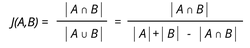



In [29]:
def j_score(y_true, y_pred) :
    J = np.minimum(y_true, y_pred).sum(axis=1)/np.maximum(y_true, y_pred).sum(axis=1)
    return J.mean()*100

def print_score(y_pred, clf) :
    Jaccard_score = j_score(y_test, y_pred)
    print('\n--------------------------------------') 
    #print("classifier : ", clf.__class__.__name__)
    print("classifier : ", clf)
    print('Jaccard Score {}'.format(Jaccard_score))
    print('--------------------------------------\n')
    return Jaccard_score


Build Models

In [31]:
from sklearn import metrics

# hold different prediction models in a single dictionary
models = {}
models["SGD"]                 = SGDClassifier(loss="hinge", penalty="l2", max_iter=20)
models["Logistic_lbfgs"]      = LogisticRegression(solver='lbfgs')
# models["SVC_1"]               = LinearSVC()
models["SVC_2"]               = LinearSVC(C=1.5, penalty = 'l1', dual=False)
# models["lp_logistic"]         = LabelPowerset(LogisticRegression())


model_results = []
model_names = []
JScores = []
precision = []
recall = []
F1_weighted = []

Hamming_loss = []

# sgd = SGDClassifier()
# lr  = LogisticRegression(solver='lbfgs')
# svc = LinearSVC()

# models = [sgd, lr, svc]

for model_name in models :
    model = models[model_name]
    
    clf = OneVsRestClassifier(model)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    
    J = print_score(y_pred, model)
    
    report_dict = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    print(report_df[-4:])
    
    model_names.append(model_name)
    JScores.append(J)

    # precision.append(f1_score(y_train, y_pred, average='micro')) 
    # ValueError: Found input variables with inconsistent numbers of samples: [39180, 9796]

    # precision.append(metrics.precision_score(y_train, y_pred, average='micro')) 
    # ValueError: Found input variables with inconsistent numbers of samples: [39180, 9796] 
    
    # recall.append(metrics.recall_score(y_train, y_pred, average='macro'))
    # ValueError: Found input variables with inconsistent numbers of samples: [39180, 9796] 

    # F1_weighted.append(metrics.f1_score(y_train, y_pred, average='weighted'))
    # ValueError: Found input variables with inconsistent numbers of samples: [39180, 9796] 

    Hamming_loss.append(hamming_loss(y_test, y_pred))

    #issue : got different values cmopared to previous run , may be because of randomness
 


--------------------------------------
classifier :  SGDClassifier(max_iter=20)
Jaccard Score 25.550394718932896
--------------------------------------

              precision    recall  f1-score  support
micro avg      0.960218  0.233736  0.375957  12082.0
macro avg      0.868638  0.197252  0.294769  12082.0
weighted avg   0.899932  0.233736  0.342427  12082.0
samples avg    0.279196  0.257154  0.263686  12082.0

--------------------------------------
classifier :  LogisticRegression()
Jaccard Score 23.52780046277392
--------------------------------------

              precision    recall  f1-score  support
micro avg      0.924843  0.219997  0.355443  12082.0
macro avg      0.864333  0.177494  0.278412  12082.0
weighted avg   0.886969  0.219997  0.337053  12082.0
samples avg    0.257409  0.239179  0.243688  12082.0

--------------------------------------
classifier :  LinearSVC(C=1.5, dual=False, penalty='l1')
Jaccard Score 62.16414863209473
--------------------------------------



In [ ]:
print(model_names)
print(JScores)
print(Hamming_loss)

<Figure size 864x576 with 0 Axes>

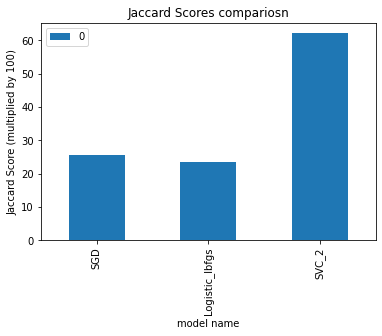

In [55]:
plt.figure(figsize = (12,8))
plotdata = pd.DataFrame(JScores, index=model_names)
# Plot a bar chart
plotdata.plot(kind="bar")
plt.title("Jaccard Scores compariosn")
plt.xlabel('model name')
plt.ylabel('Jaccard Score (multiplied by 100)')
plt.show()

<Figure size 864x576 with 0 Axes>

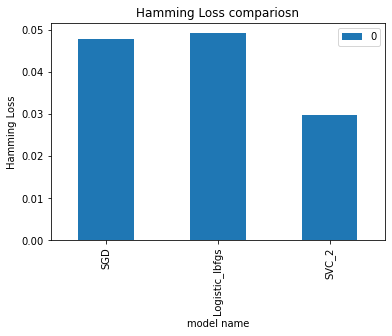

In [56]:
plt.figure(figsize = (12,8))
plotdata = pd.DataFrame(Hamming_loss, index=model_names)
# Plot a bar chart
plotdata.plot(kind="bar")
plt.title("Hamming Loss compariosn")
plt.xlabel('model name')
plt.ylabel('Hamming Loss')
plt.show()

MLkNN with hyperparameter optimization using Grid Search

In [ ]:
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

parameters = {'k': range(1,10), 's': [0.5, 0.7, 1.0]}

clf = GridSearchCV(MLkNN(), parameters, scoring='f1_micro')
clf.fit(X_train, y_train)

print (clf.best_params_, clf.best_score_)

In [ ]:
# t0 = time.time()
# clf = MLkNN(k = 3)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# t1 = time.time()
# print("time taken to predict using MLkNN(k=3) : ", t1-t0)

After Grid Search, found optimal value of k=9. Running MLkNN with k = 9

In [81]:
t0 = time.time()
clf = MLkNN(k = 9)
print(clf)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
t1 = time.time()
print("time taken to predict : ", t1-t0)

MLkNN(k=9)
time taken to predict :  158.6962947845459


In [83]:
report_dict = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df[-4:]

,precision,recall,f1-score,support
micro avg,0.680075,0.481377,0.563730,12082.0
macro avg,0.635348,0.441656,0.515153,12082.0
weighted avg,0.666415,0.481377,0.553882,12082.0
samples avg,0.515380,0.510829,0.498747,12082.0


In [84]:
# print(jaccard_score(y_test, y_pred, average=None))
print("Jaccard score (samples average) : ", jaccard_score(y_test, y_pred, average='samples'))
print("Jaccard score (micro average) : ", jaccard_score(y_test, y_pred, average='micro'))
print("Jaccard score (macro average) : ", jaccard_score(y_test, y_pred, average='macro'))

Jaccard score (samples average) :  0.4694943514359602
Jaccard score (micro average) :  0.39249561344310974
Jaccard score (macro average) :  0.35764789923599993


Testing with  new Question(s) using previously trained MLkNN

In [119]:
print("Please enter question(s) related to the following topics : ")
print(mlb.classes_)

Please enter question(s) related to the following topics : 
['.net' 'android' 'asp.net' 'c' 'c#' 'c++' 'css' 'html' 'ios' 'iphone'
 'java' 'javascript' 'jquery' 'mysql' 'objective-c' 'php' 'python' 'ruby'
 'ruby-on-rails' 'sql']


In [125]:
models["MLkNN"] = clf

In [132]:
models

{'SGD': SGDClassifier(max_iter=20),
 'Logistic_lbfgs': LogisticRegression(),
 'SVC_2': LinearSVC(C=1.5, dual=False, penalty='l1'),
 'MLkNN': MLkNN(k=9)}

In [ ]:
while(True) :
    question = input("Please type your questiion bellow : ")
    temporary_list = []
    temporary_list.append(question)
    xt = tfidf.transform(temporary_list)
    del temporary_list
    y_hat = models['MLkNN'].predict(xt)
    tags = mlb.inverse_transform(y_hat)
    print("Predicted Tags : ", tags)

Please type your questiion bellow : How can I learn ml in c++, java and python
Predicted Tags :  [('java', 'python')]
